# Applying the perceptron theory

Now, we are diving into the heart of it! Programming our first neural network using `pytorch`.

Note, run all the cells every time to prevent unwanted errors.


In [71]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from matplotlib import pyplot as plt
%matplotlib inline


In [72]:
# Load dataset
filename = "./data/iris.csv"
df = pd.read_csv(filename)
df = df.sample(frac=1).reset_index(drop=True) # Shuffle dataframe
df.head()
print(df.shape)
print(df["species"].value_counts())

(150, 5)
Iris-versicolor    50
Iris-setosa        50
Iris-virginica     50
Name: species, dtype: int64


In [73]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.6,3.0,4.1,1.3,Iris-versicolor
1,5.1,2.5,3.0,1.1,Iris-versicolor
2,5.0,3.3,1.4,0.2,Iris-setosa
3,6.4,3.2,5.3,2.3,Iris-virginica
4,6.7,2.5,5.8,1.8,Iris-virginica


In [74]:
df['species'].unique()

array(['Iris-versicolor', 'Iris-setosa', 'Iris-virginica'], dtype=object)

In [75]:
# Creating a test/train split
train_test_split_fraction = 0.80
split_index = int(df.shape[0] * train_test_split_fraction)
df_train = df[:split_index]
df_test = df[split_index:]

target = pd.get_dummies(df['species']).values # One hot encode
target[:5]

array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [76]:
# Selecting the features and the target
X_train = df_train.drop('species', axis = 1).values
X_test = df_test.drop('species', axis = 1).values

y_train = target[:split_index]
y_test = target[split_index:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(120, 4)
(30, 4)
(120, 3)
(30, 3)


In [89]:
print(y_test)

tensor([[0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0]])


Transform `X_train`, `y_train` and their test counterparts into pytorch tensors using `torch.tensor()`. Make sure to convert them to float32 with numpy.

In [ ]:
#Method 1
# wrap up with Variable in pytorch
#train_X = Variable(torch.Tensor(train_X).float())
#test_X = Variable(torch.Tensor(test_X).float())
#train_y = Variable(torch.Tensor(train_y).long())
#test_y = Variable(torch.Tensor(test_y).long())

In [77]:
#Method_2
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [78]:
X_train[:5]

tensor([[5.6000, 3.0000, 4.1000, 1.3000],
        [5.1000, 2.5000, 3.0000, 1.1000],
        [5.0000, 3.3000, 1.4000, 0.2000],
        [6.4000, 3.2000, 5.3000, 2.3000],
        [6.7000, 2.5000, 5.8000, 1.8000]])

In [95]:
y_train = (y_train == 1).nonzero(as_tuple=True)[1]
print(y_train)

tensor([1, 1, 0, 2, 2, 1, 0, 0, 2, 2, 2, 1, 2, 0, 2, 2, 0, 0, 0, 0, 2, 2, 1, 1,
        0, 0, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 0, 2, 0, 2, 1, 2, 0, 1, 0, 2, 1, 2, 2, 0, 2, 1, 2, 1, 2, 2, 2, 0,
        2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 0, 1, 2, 2, 1, 0, 1, 1, 0, 2, 0, 0, 2, 1,
        2, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 2, 1, 0, 1, 0, 2, 1, 0, 1, 0])


In [96]:
y_test = (y_test == 1).nonzero(as_tuple=True)[1]
print(y_test)

tensor([1, 0, 2, 0, 2, 1, 2, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 2, 2, 0, 2, 2, 2, 1,
        0, 1, 0, 1, 1, 1])


In [79]:
y_train[:5]

tensor([[0, 1, 0],
        [0, 1, 0],
        [1, 0, 0],
        [0, 0, 1],
        [0, 0, 1]])

Now that we have selected our train and test sets, we have to create the neural network architecture.

In [80]:
nb_hidden_neurons = 10
nb_classes = len(pd.unique(df['species']))
nb_classes

3

The `nn.Linear()` method defines a layer of neurons in the neural network.
We want the network to have 10 neurons in the middle layers and 3 in the last layer (one for every class).

Notice how we define the layers in `__init__()`, and we connect them in `forward()` .

In the code below in the `__init__()` function,  complete the code for `self.layer_1`, `self.layer_2` , and `self.layer_3` using the `nn.Linear()` class to add the desired layers. *Hint: Make use of `nb_features` and `nb_hidden_neurons`. You can also refer to the architecture of the network shown in the image a few cells below*.

In the `forward()` function, which is going to handle the forward pass of the neural network learning process, we will use the ReLU activation function for the first layers and for the last layer, we are going to use the Softmax activation function.
We want you to assign the ReLU activation function to the variable `activation_function`. More information [here](https://pytorch.org/docs/stable/nn.html).
Lastly, we want you to write the code to combine the layers to the input `x` and the output. *Hint: You can refer yourself to how the last layer code is written*.


In [81]:
import torch.nn as nn

class Network(nn.Module):

    def __init__(self, nb_features):
        """Here we define the layers
        """

        super().__init__()
        
        self.layer_1 = nn.Linear(nb_features,10) 
        self.layer_2 =  nn.Linear(10, 10) 
        self.layer_3 =  nn.Linear(10, 3) 
        self.relu = nn.ReLU()
        

    def forward(self,x):
        """Here we combine the layers
        """
        
        #activation_function = nn.ReLU()#TO COMPLETE 
        last_layer_activation = nn.Softmax(dim=1)
        
        output_first_layer = self.relu(self.layer_1(x)) #TO COMPLETE 
        output_second_layer = self.relu(self.layer_2(output_first_layer)) #TO COMPLETE
        prediction = last_layer_activation(self.layer_3(output_second_layer))
        return prediction

In [82]:
my_nn = Network(nb_features=X_train.shape[1])
my_nn

Network(
  (layer_1): Linear(in_features=4, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

If you did everything right, this should be the output of the previous call

```
Network(
  (layer_1): Linear(in_features=4, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=3, bias=True)
)
```

Now, we have done the architecture of the model. Right now, it does nothing. We have to make it learn.

First, we'll need to define the `criterion` by which the cost if calculated.
There are many possible losses to choose from (see #Additional reading material), but here we're going to choose the `MSELoss`.
The piece of code that is going to compute the gradient and change the weights is called an `optimizer`.
Again, there are many to choose from (see #Additional reading material), but here we are going to use the `Adam` optimizer with a `learning_rate` of `0.001`.

In [83]:
# creating our optimizer and loss function object
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01 
optimizer = torch.optim.Adam(my_nn.parameters(),lr=learning_rate)

Now, we can start training the neural network. Below, the `training()` function handles all the necessary stuff for an efficient training process.
The loops, the input and output getting, and the loss plotting are already taken care of.
You just have to do the most important part of the training process, which is listed as a comment.

You can run the function with the next cell, which will also plot a graph of the loss over the whole training.

In [99]:
def training(X_train, y_train, batch_size : int, nb_steps_loss_sum : int):
    """ Train the neural network, feeding it `batch_size` at a time
    and saving statistics every `nb_steps_loss_sum` steps.
    
    Arguments:
    
    - batch_size [int] : the number of input samples at each training step (called a batch)
    - nb_steps_loss_sum [int] : the number of batches before saving the loss for plotting
    
    Returns:
    - loss_list : [List[double]] : value of the loss every `nb_steps_loss_sum` steps
    """

    loss_list = []
    running_loss = 0
    batch_nb = 0

    for epoch in range(0,10): # Number of times to iterate through the complete dataset
        for idx in range(0, X_train.shape[0], batch_size):
            
            # Get input and output
            input_batch = X_train[idx:idx + batch_size]
            target = y_train[idx:idx + batch_size]
            
            # TO COMPLETE:
            optimizer.zero_grad() #zero gradient buffers
            output_train = my_nn(X_train) #compute the forward pass
            loss_train = criterion(output_train, y_train) #- compute the loss
            loss_train.backward() # backpropagate
            optimizer.step() #do a step
          
            
            # Save the loss every `running_loss_steps` batches
            running_loss += loss_train.item()
            save_loss_condition = batch_nb % nb_steps_loss_sum == (nb_steps_loss_sum - 1)
            if save_loss_condition:    
                loss_list.append(running_loss)
                running_loss = 0.0


            batch_nb+= 1
        
    return loss_list


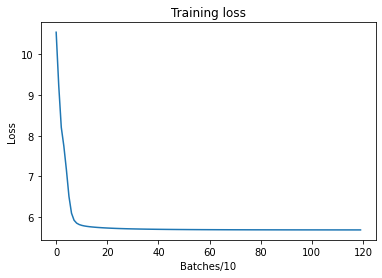

In [100]:
nb_steps_loss_sum = 10
loss = training(X_train, y_train, batch_size=1, nb_steps_loss_sum=nb_steps_loss_sum)

# Plotting the loss over training
plt.figure()
plt.plot(range(0, len(loss)), loss)
plt.xlabel(f"Batches/{nb_steps_loss_sum}")
plt.ylabel("Loss")
plt.title("Training loss")
plt.show()
plt.close()

If everything went to plan, you should have a decreasing loss over time. Something similar to this:
    
![Training Loss](./assets/loss.png)

The function below will compute the accuracy of the neural network. You have to complete the steps outlined.

In [101]:
def computeScore(X, y):
    correct = 0
    total = 0
    batch_size = 1
    my_nn.eval()
    with torch.no_grad():
        for idx in range(0, X.shape[0], batch_size):
            # TO COMPLETE:
            # - get the `batch_size` number of input samples
            # - compute the prediction of the neural network
            # - get the max of the prediction (e.g. get the most likely class)
            # This can be done using `torch.max`.
            # - get the max of the target (e.g. correct class)
            # - check if the prediction is correct and count it
            # - count every sample
            
    accuracy = correct/total * 100
    print(f"Accuracy of the network on the {total} samples: {accuracy:.2f}%")

IndentationError: expected an indented block (4044620145.py, line 17)

In [ ]:
computeScore(X_train, y_train)
computeScore(X_test, y_test)

NameError: name 'computeScore' is not defined

If you compute the score, and have done everything correctly (and you are lucky), you should have an accuracy of 90% and above.
```
Accuracy of the network on the 120 samples: 96.67%
Accuracy of the network on the 30 samples: 96.67%
```

However, you might notice, if you repeat the runs, you might get totally different scores, even if all else stays the same.

**Why does that happen ? Can you explain ?** *Hint: It might have something to do with degrees of freedom*

> Explain here

## Additional reading material
[How to build a simple neural network in pytorch](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)

[Introduction to optimizers](https://algorithmia.com/blog/introduction-to-optimizers)

[What loss function to choose](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/)

[Visualizing optimizers (Interactive)](https://emiliendupont.github.io/2018/01/24/optimization-visualization/)

[What are degrees of freedom?](https://machinelearningmastery.com/degrees-of-freedom-in-machine-learning/)